# Information-based Models
With the aid of Bagehot's contributions ([The Only Game in Town](https://www.studocu.com/in/document/madras-school-of-economics/economics/the-only-game-in-town/26975726)), and Copeland & Galai's model ([Information Effects on the Bid-Ask Spread](https://www.jstor.org/stable/2327580?read-now=1&oauth_data=eyJlbWFpbCI6Imx1aXNmZWxpcGVnb21lemVzdHJhZGFAZ21haWwuY29tIiwiaW5zdGl0dXRpb25JZHMiOltdLCJwcm92aWRlciI6Imdvb2dsZSJ9&seq=5)) demonstrated how, even without transaction costs, a spread would exist. This led us to maximize the market maker's profit function in terms of a Bid & Ask price.

 

Now let's try to implement this using python.


## Parameters

- $P \sim \operatorname{Lognormal}(60,2.25)$ : Stock price follows a normal distribution
- $\Pi_I=0.4$ : Probability of an informed trade
- $\Pi_{L B}(S)=0.5-0.08 S$ where $\Pi_{L B}:[0,0.5]$, and $S=\left(A-S_0\right)$
- $\Pi_{L S}(S)=0.5-0.08 S$ where $\Pi_{L S}:[0,0.5]$, and $S=\left(S_0-B\right)$
- $S_0=65$

## Deliverables

- A jupyter notebook containing:
    - Plot the price distribution
    - Create a plot showing:
        - Expected revenue if all trades are liquidity trades, and $\Pi_{L B}=\Pi_{L S}=0.5$
        - Expected revenue if there is a $40 \%$ chance that an informed trade will be executed, keep the same liquidity probabilities as the previous point.
        - Expected revenue considering:
            - $\Pi_I=0.4$
            - $\Pi_{L B}(S)=0.5-0.08 S$ where $\Pi_{L B}:[0,0.5]$
            - $\Pi_{L S}(S)=0.5-0.08 S$ where $\Pi_{L S}:[0,0.5]$
    - Determine the optimal Bid / Ask price using Copeland \& Galai's model with the defined parameters.
    

## Use this wisely

\begin{aligned}
& \max _{K_A, K_B}\left\{\left(1-p_I\right)\left[p_{B L}\left(K_A-S_0\right)+p_{S L}\left(S_0-K_B\right)\right]\right. \\
&\left.-p_I\left[\int_{K_A}^{\infty}\left(S-K_A\right) f(S) d S+\int_0^{K_B}\left(K_B-S\right) f(S) d S\right]\right\} \geq 0
\end{aligned}

In [1]:
# paqueterias 
from scipy.integrate import quad
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.stats import lognorm

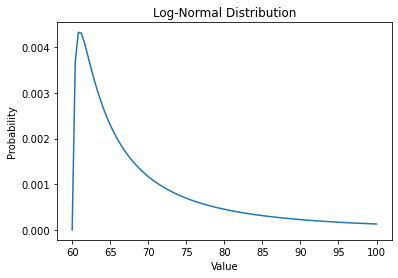

In [26]:
# Set parameters for the log-normal distribution
mu = 60  # mean
sigma = 2.25**.5  # standard deviation

def lognorm(x):
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x - mu) ** 2) / (2 * sigma**2))

# Generate random data from a log-normal distribution
x_ = np.linspace(60.001, 100, 100)
y_ = lognorm(x_)

# Plot the histogram of the data
plt.plot(x_, y_)

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Log-Normal Distribution')

# Show the plot
plt.show()


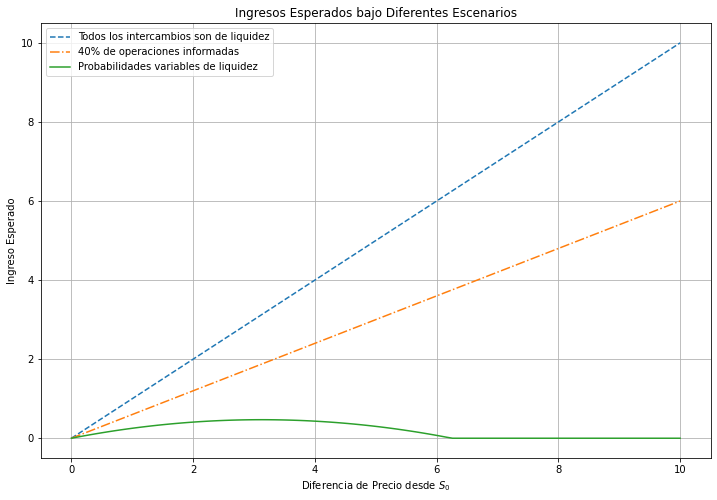

In [29]:


# Parámetros dados
pi_I = 0.4  # Probabilidad de una operación informada
S0 = 65  # Precio de referencia

# Funciones de probabilidad de liquidez
def pi_LB(S):
    return np.maximum(0.5 - 0.08 * S, 0)

def pi_LS(S):
    return np.maximum(0.5 - 0.08 * S, 0)

# Rango de diferencias de precios para la evaluación
delta_prices = np.linspace(0, 10, 100)

# Escenario 1: Todos los intercambios son de liquidez
revenue_liquidity_only = delta_prices

# Escenario 2: 40% de operaciones informadas
revenue_informed = (1 - pi_I) * (delta_prices)

# Escenario 3: Probabilidades variables de liquidez
revenue_variable_liquidity = (1 - pi_I) * (pi_LB(delta_prices) * delta_prices)

# Graficar los ingresos esperados para los tres escenarios
plt.figure(figsize=(12, 8))
plt.plot(delta_prices, revenue_liquidity_only, label="Todos los intercambios son de liquidez", linestyle="--")
plt.plot(delta_prices, revenue_informed, label="40% de operaciones informadas", linestyle="-.")
plt.plot(delta_prices, revenue_variable_liquidity, label="Probabilidades variables de liquidez", linestyle="-")
plt.title("Ingresos Esperados bajo Diferentes Escenarios")
plt.xlabel("Diferencia de Precio desde $S_0$")
plt.ylabel("Ingreso Esperado")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
from scipy.integrate import quad

# Parámetros definidos
mu = 60
sigma = (2.25)**.5
pi_I = 0.4  # Probabilidad de una operación informada
S0 = 65  # Precio de referencia



# Funciones de probabilidad de liquidez ajustadas
def pi_LB(S):
    return np.maximum(0.5 - 0.08 * S, 0)

def pi_LS(S):
    return np.maximum(0.5 - 0.08 * S, 0)

# Función objetivo para maximizar (negativo de la función de beneficio)
def objective(x):
    KA, KB = x  # KA = Precio Ask, KB = Precio Bid
    S_A = KA - S0  # Diferencia entre Ask y precio de referencia
    S_B = S0 - KB  # Diferencia entre Bid y precio de referencia
    
    # Calcular la parte de beneficio por liquidez
    liquidity_profit = (1 - pi_I) * (pi_LB(S_A) * S_A + pi_LS(S_B) * S_B)
    
    # Calcular la parte de pérdida por operaciones informadas
    informed_loss = pi_I * (
        quad(lambda S: (S - KA) * lognorm(S), KA, 100)[0] +
        quad(lambda S: (KB - S) * lognorm(S), 60.0001, KB)[0]
    )
    
    # La función de optimización busca minimizar, por lo tanto, tomamos el negativo del beneficio neto
    return -(liquidity_profit - informed_loss)

# Condiciones iniciales y límites para la optimización
initial_guess = [S0 + 1, S0 - 1]  # Estimaciones iniciales para precios Ask y Bid
bounds = [(S0, None), (60.0001, S0)]  # Límites razonables para Ask y Bid

# Resolver el problema de optimización
result = opt.minimize(objective, initial_guess, bounds=bounds)

# Mostrar los resultados
KA_optimal, KB_optimal = result.x
print(f"Precio óptimo de venta (Ask): {KA_optimal:.2f}")
print(f"Precio óptimo de compra (Bid): {KB_optimal:.2f}")


Precio óptimo de venta (Ask): 68.19
Precio óptimo de compra (Bid): 61.85


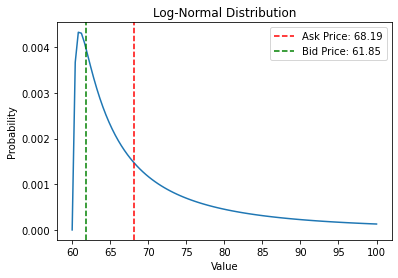

In [42]:
# Set parameters for the log-normal distribution
mu = 60  # mean
sigma = 2.25**.5  # standard deviation

def lognorm(x):
    return (1 / (x * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(x - mu) ** 2) / (2 * sigma**2))

# Generate random data from a log-normal distribution
x_ = np.linspace(60.001, 100, 100)
y_ = lognorm(x_)

# Plot the histogram of the data
plt.plot(x_, y_)

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Log-Normal Distribution')

# Lineas punteadas para los precios óptimo de venta (Ask) y compra (Bid)
ask_price = KA_optimal
bid_price = KB_optimal

plt.axvline(ask_price, color='r', linestyle='--', label=f'Ask Price: {KA_optimal:.2f}')
plt.axvline(bid_price, color='g', linestyle='--', label=f'Bid Price: {KB_optimal:.2f}')

# Adding legend to distinguish the lines
plt.legend()

# Show the plot
plt.show()
